# Healthcare/Stroke Dataset Classifier Analysis

This notebook consists of analysis of the best binary classifier for the stroke dataset. I will explore many different models and provide my analysis for each, making an overall conclusion about the best model.

I will just use the `scikit-learn` library to train the models and obtain predictions. Ideally, I'd use some custom classes to obtain more helpful diagnostics for each model, but I want to keep things simple given how many different classification models will be implemented. While a black box, `scikit-learn` does produce similar results as the algorithms presented in class and in our own repositories.

**Feature Sets Analyzed:**
1. Full 10 features
2. 3 features (age, avg_glucose_level, bmi) following feature selection
    * Also with **random undersampling/oversampling**

**Classification Models Analyzed:**
1. The Perceptron
2. Logistic Regression
3. Dense Neural Networks (Multilayer Perceptron)
4. *k*-Nearest Neighbors
5. Decision Trees
6. Bagging/Random Forests
7. Voting
8. Boosting (Gradient Boosting)

In [1]:
## Import necessary libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import classification models
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Import useful functions used to evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from mlxtend.evaluate import bias_variance_decomp
from sklearn.feature_selection import SelectFromModel

# Import resampling methods to deal with imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# surpress deprecation warnings, such as those from KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore') 

## Data Processing

Exploratory data analysis was performed in class, see this notebook [here.](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/class_exercise_3-31/stroke_exploratory.ipynb)

In [2]:
# Read in the data set
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In class, we found that there were only 201 missing values, all in the `bmi` column. These observations will simply be dropped.

In [3]:
df_cleaned = df.dropna()

Next, note that the `gender`, `ever_married`, `work_type`, `residence_type`, and `smoking_status` variables are categorical. If these variables are to be used in the models, they need to be converted to a numerical scale. Ideally, the non-binary variables should be arranged into an ordinal scale, but it is hard to determine an order these variables such as `work_type`.

In [4]:
df_cleaned.gender = df_cleaned.gender.map({"Male": 0, "Female": 1, "Other": 2})
df_cleaned.ever_married = df_cleaned.ever_married.map({"No": 0, "Yes": 1})
df_cleaned.work_type = df_cleaned.work_type.map({"Private": 0, "Self-employed": 1, "children": 2, "Govt_job": 3, "Never_worked": 4})
df_cleaned.Residence_type = df_cleaned.Residence_type.map({"Rural": 0, "Urban": 1})
df_cleaned.smoking_status = df_cleaned.smoking_status.map({"never smoked": 0, "Unknown": 1, "formerly smoked": 2, "smokes": 3})

In [5]:
df_cleaned = df_cleaned.drop("id", axis = 1)
df_cleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,1,228.69,36.6,2,1
2,0,80.0,0,1,1,0,0,105.92,32.5,0,1
3,1,49.0,0,0,1,0,1,171.23,34.4,3,1
4,1,79.0,1,0,1,1,0,174.12,24.0,0,1
5,0,81.0,0,0,1,0,1,186.21,29.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,1,13.0,0,0,0,2,0,103.08,18.6,1,0
5106,1,81.0,0,0,1,1,1,125.20,40.0,0,0
5107,1,35.0,0,0,1,1,0,82.99,30.6,0,0
5108,0,51.0,0,0,1,0,0,166.29,25.6,2,0


This is the cleaned data set that will be split into a training/testing set to find the best binary classifier. I will proceed with all of these variables because analysis of the correlation matrix in class told us that there weren't any pairs of variables with high correlation; it will be interesting to see what happens.

## Training a Binary Classifier

In the next sections, I will be training different classification models to see what the best one is. This will involve analyzing the model's accuracy in predictions. 

For example, the code below (which was the example posted on Canvas) implements a random forest classifier and evaluates the model's accuracy on test data versus just blindly guessing 0 for all predictions.

In [6]:
df_num = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].dropna()
X, y = df_num[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']], df_num['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# predict with the trained model
y_pred = rf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred) = } \n')

# always predict 0
y_zeros = np.zeros(y_test.shape)
print(f'{accuracy_score(y_test, y_zeros) = }')

accuracy_score(y_test, y_pred) = 0.945010183299389 

accuracy_score(y_test, y_zeros) = 0.9460285132382892


Observe that the accuracy score when making predictions from the model is lower than if you had guessed 0 for all predictions. Consequently, I conclude that this model could do better, and is not the best way to predict occurrence of a stroke given the 5 predictors used to train.

#### Some helpful functions I will be using

The function below plots a confusion matrix, which will be helpful in identifying the number of correct classifications for each class. It also can quickly inform about the type I/II errors.

In [7]:
def plot_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    classes = [1, 0] # want to invert the order of the classes in outputted matrix
    # Obtain confusion matrix
    cf_matrix = confusion_matrix(y_actual, y_pred,  labels=[1, 0])

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel('\nPredicted Values', fontsize = 12)
    ax.set_ylabel('Actual Values ', fontsize = 12)
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

Sometimes it can be difficult to determine what model to proceed with based on accuracy (can achieve higher accuracy with more complexity, see Decision Tree section), and examining the bias/variance can help make an informed decision.

In [8]:
def print_bias_variance(model, X_train, y_train, X_test, y_test):
    """
    Print the bias and variance decomposition for a model.
    A model with high bias and low variance may underfit the data, 
    while a model with low bias and high variance may overfit the data.
    """
    mse, bias, var = bias_variance_decomp(
         model, X_train.values, y_train.values, X_test.values, y_test.values, loss = 'mse', random_seed = 123)
    print('MSE: %.3f' % mse) # aka Expected Loss
    print('Bias: %.3f' % bias)
    print('Variance: %.3f' % var)

It would be good to plot decision boundaries for each model, but since the features are multi-dimensional (more than 2-D), it will be hard to visualize meaningfully.

## Model 1: The Perceptron

#### Defining the training set

Analysis of the correlation matrix in class told us that there weren't any pairs of variables with high correlation. I am just going to include all variables (including categorical ones) in `df_cleaned` and see what happens.

The data will be split into a training and testing set using the 80/20 rule of the Pareto principle. This same split will be consistent across all models that will be trained in this notebook, meaning the training observations and testing observations will remain consistent for analysis.

In [9]:
X, y = df_cleaned.loc[:, df_cleaned.columns != "stroke"], df_cleaned['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Recall that the data is unbalanced. It would be a good exercise to ensure that the training data set is representative through visualizations, but I just observe that the training and testing data have similar ratios for 0's vs. 1's and proceed with model training. Besides, I will be implementing ensemble methods, which helps train a better model for classification tasks with unbalanced data.

In [10]:
y_train.value_counts()

0    3771
1     156
Name: stroke, dtype: int64

In [11]:
y_test.value_counts()

0    929
1     53
Name: stroke, dtype: int64

#### Finding the best model under different learning rates

In [12]:
learning_rates = [0.8, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for eta in learning_rates:
    per_model = Perceptron(eta0 = eta, max_iter = 5000, random_state = 42)
    per_model.fit(X_train, y_train)
    print(f"rate = {eta}: {per_model.score(X_train, y_train)}")

rate = 0.8: 0.949834479246244
rate = 0.5: 0.949834479246244
rate = 0.25: 0.949834479246244
rate = 0.1: 0.949834479246244
rate = 0.01: 0.949834479246244
rate = 0.001: 0.949834479246244
rate = 0.0001: 0.949834479246244
rate = 1e-05: 0.949834479246244


No differences in training accuracy under different learning rates, so I'll just use 0.0001.

#### Performance/Error Analysis

In [13]:
per_model = Perceptron(eta0 = 0.0001, max_iter = 5000, random_state = 42)
per_model.fit(X_train, y_train)

print("Training accuracy:", per_model.score(X_train, y_train))
print("Testing accuracy:", per_model.score(X_test, y_test))

Training accuracy: 0.949834479246244
Testing accuracy: 0.9439918533604889


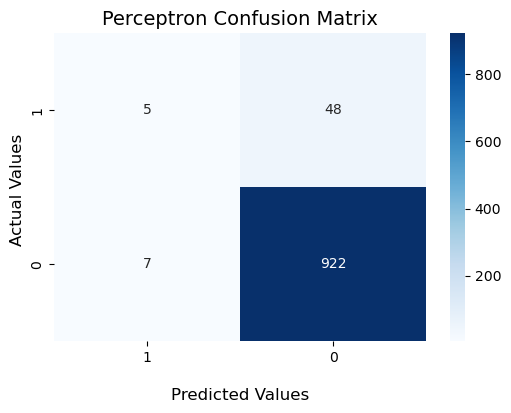

In [14]:
y_pred = per_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Perceptron Confusion Matrix", fontsize = 14)
plt.show()

## Model 2: Logistic Regression

There doesn't appear to be an option to change parameters to train a logistic regression model using scikit-learn, so I'll just move forwards with the default.

#### Performance/Error Analysis

In [15]:
log_model = LogisticRegression(random_state = 42)
log_model.fit(X_train, y_train)
print("Training accuracy:", log_model.score(X_train, y_train))
print("Testing accuracy:", log_model.score(X_test, y_test))

Training accuracy: 0.9605296664120193
Testing accuracy: 0.9460285132382892


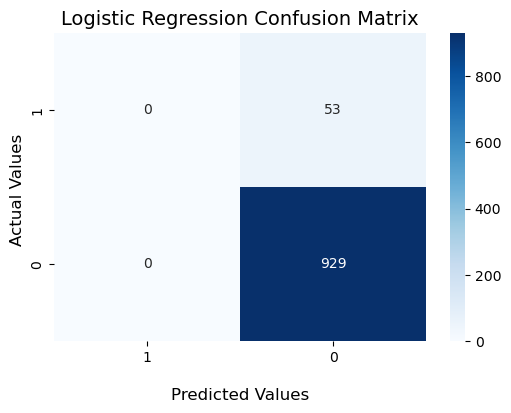

In [16]:
y_pred = log_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Logistic Regression Confusion Matrix", fontsize = 14)
plt.show()

## Model 3: Dense Neural Networks (Multilayer Perceptron)

#### Finding the best model under different learning rates

In [17]:
for lr in learning_rates:
    mlp_model = MLPClassifier(learning_rate_init = lr, max_iter = 500, random_state = 42)
    mlp_model.fit(X_train, y_train)
    print(f"rate = {lr}: {mlp_model.score(X_train, y_train)} with {mlp_model.n_layers_} layers")

rate = 0.8: 0.9602750190985485 with 3 layers
rate = 0.5: 0.9602750190985485 with 3 layers
rate = 0.25: 0.9602750190985485 with 3 layers
rate = 0.1: 0.9602750190985485 with 3 layers
rate = 0.01: 0.9602750190985485 with 3 layers
rate = 0.001: 0.9582378405907818 with 3 layers
rate = 0.0001: 0.959511077158136 with 3 layers
rate = 1e-05: 0.9592564298446652 with 3 layers


In [18]:
mlp_model = MLPClassifier(learning_rate_init = 0.01, max_iter = 500, random_state = 42)
mlp_model.fit(X_train, y_train)

print("Training accuracy:", mlp_model.score(X_train, y_train))
print("Testing accuracy:", mlp_model.score(X_test, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


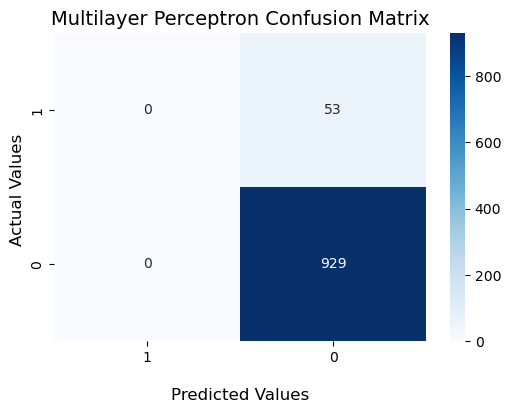

In [19]:
y_pred = mlp_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Multilayer Perceptron Confusion Matrix", fontsize = 14)
plt.show()

## Model 4: *k*-Nearest Neighbors

#### Finding the optimal k

In [20]:
knn_accuracy = []
#possible_k = range(3, int(np.ceil(np.sqrt(X_train.shape[0]))))
possible_k = range(3, 16)
for k in possible_k:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    knn_accuracy.append(knn.score(X_train, y_train))

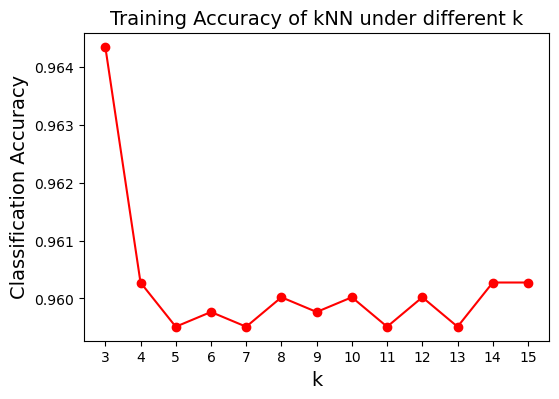

In [21]:
plt.figure(figsize = (6, 4))
plt.plot(possible_k, knn_accuracy, color = 'red', marker = "o")
plt.title("Training Accuracy of kNN under different k", fontsize = 14)
plt.xlabel('k', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)
plt.xticks(possible_k)
plt.show()

The classification accuracy is highest when k = 3, so that is what I will proceed with.

#### Performance/Error Analysis

In [22]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

print("Training accuracy:", knn.score(X_train, y_train))
print("Testing accuracy:", knn.score(X_test, y_test))

Training accuracy: 0.964349376114082
Testing accuracy: 0.9348268839103869


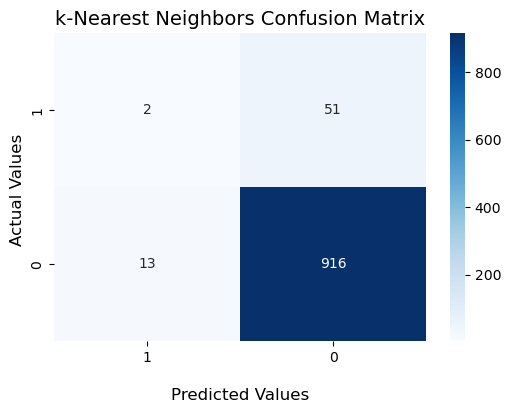

In [23]:
y_pred = knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("k-Nearest Neighbors Confusion Matrix", fontsize = 14)
plt.show()

## Model 5: Decision Trees

#### Finding the optimal depth

In [24]:
# Obtain the accuracy for a range of depths for plotting
tree_accuracy = []
possible_depth = range(2, 21)
for d in possible_depth:
    tree_model = DecisionTreeClassifier(max_depth = d, random_state = 42)
    tree_model.fit(X_train, y_train)
    tree_accuracy.append(tree_model.score(X_train, y_train))

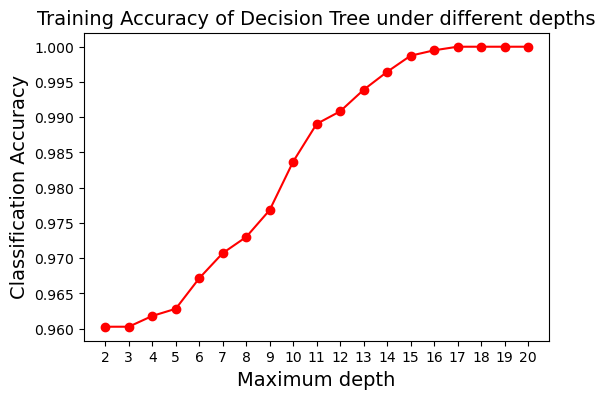

In [25]:
plt.figure(figsize = (6, 4))
plt.plot(possible_depth, tree_accuracy, color = 'red', marker = "o")
plt.title("Training Accuracy of Decision Tree under different depths", fontsize = 14)
plt.xlabel('Maximum depth', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)
plt.xticks(possible_depth)
plt.show()

To maximize accuracy, the maximum depth of the tree should be 17. Anything beyond 17 would be overfitting without a significant gain in accuracy. However, realize that the training accuracy at this point is greater than 99% already. This accuracy is super high; even at `max_depth=11` there is 99% training accuracy and `max_depth=2` has 96% training accuracy as well. I need another metric to evaluate what the best model is, so that I don't pick something that will definitely overfit.

One way to approach this is to note the bias/variance tradeoff. A model with high bias and low variance may underfit the data, while a model with low bias and high variance may overfit the data. I want to balance both the bias and variance.

In [26]:
# Obtain the bias/variance for each max_depth Decision Tree for plotting
biases = []
variances = []
for d in possible_depth:
    tree_model = DecisionTreeClassifier(max_depth = d, random_state = 42)
    tree_model.fit(X_train, y_train)
    _, bias, var = bias_variance_decomp(tree_model,
        X_train.values, y_train.values, X_test.values, y_test.values, loss = 'mse', random_seed = 123)
    biases.append(bias)
    variances.append(var)

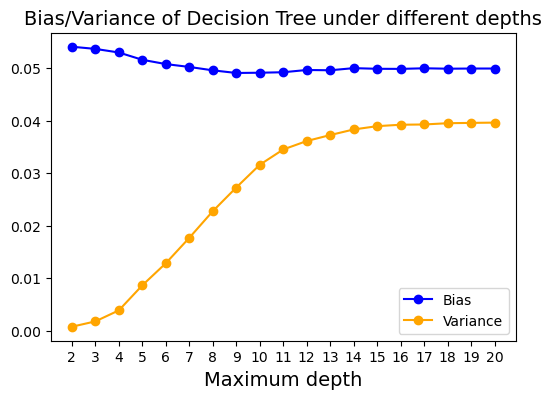

In [27]:
plt.figure(figsize = (6, 4))
plt.plot(possible_depth, biases, color = 'blue', marker = "o", label = "Bias")
plt.plot(possible_depth, variances, color = 'orange', marker = "o", label = "Variance")
plt.title("Bias/Variance of Decision Tree under different depths", fontsize = 14)
plt.xlabel('Maximum depth', fontsize = 14)
plt.xticks(possible_depth)
plt.legend(loc = "lower right")
plt.show()

Bias slightly decreases as the depth increases initially, but then remains mostly consistent. Thus, the focus will be the variance. The variance cannot be too high or there will be overfitting. Examining this plot and the previous accuracy plot, I think I will examine two models. 

The first is a Decision Tree with maximum depth of 11 because beyond this point, an increase in the depth does not increase the classification accuracy by much. Variance is esentially at the highest too, beyond this point there are no significant increases.

The second is a Decision Tree with a maximum depth of 7. I think a depth of 11 might still be too overfit as suggested by the training accuracy of 99%. Furthermore, the variance is at the highest at a depth of 11. I'm curious what happens when I move towards the left of the curve with lower variance and a slightly higher bias.

#### Performance/Error Analysis (max_depth=11)

In [28]:
tree_model11 = DecisionTreeClassifier(max_depth = 11, random_state = 42)
tree_model11.fit(X_train, y_train)

# from sklearn.tree import plot_tree
# Would be good to display the actual tree but this one is too large

print("Training accuracy:", tree_model11.score(X_train, y_train))
print("Testing accuracy:", tree_model11.score(X_test, y_test))

Training accuracy: 0.9890501655207538
Testing accuracy: 0.9215885947046843


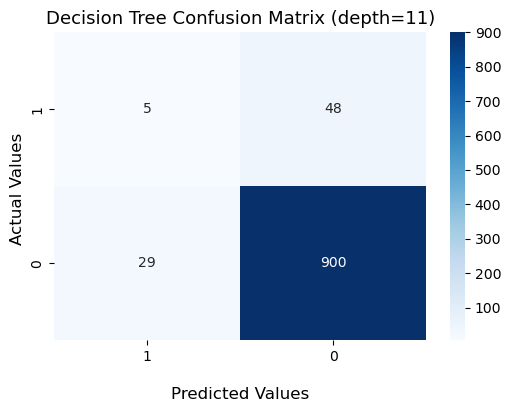

In [29]:
y_pred = tree_model11.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Decision Tree Confusion Matrix (depth=11)", fontsize = 13)
plt.show()

In [30]:
print_bias_variance(tree_model11, X_train, y_train, X_test, y_test)

MSE: 0.084
Bias: 0.049
Variance: 0.035


#### Performance/Error Analysis (max_depth=7)

In [31]:
tree_model7 = DecisionTreeClassifier(max_depth = 7, random_state = 42)
tree_model7.fit(X_train, y_train)

# from sklearn.tree import plot_tree
# Would be good to display the actual tree but this one is too large

print("Training accuracy:", tree_model7.score(X_train, y_train))
print("Testing accuracy:", tree_model7.score(X_test, y_test))

Training accuracy: 0.970715558950853
Testing accuracy: 0.9368635437881874


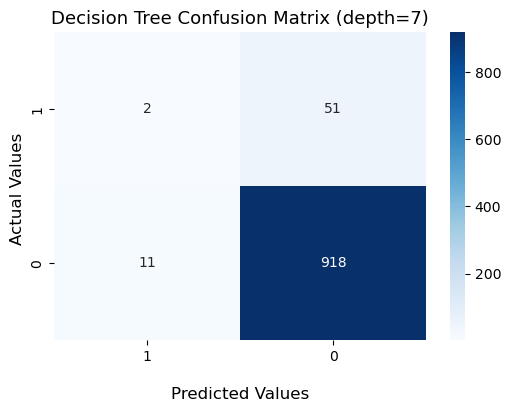

In [32]:
y_pred = tree_model7.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Decision Tree Confusion Matrix (depth=7)", fontsize = 13)
plt.show()

In [33]:
print_bias_variance(tree_model7, X_train, y_train, X_test, y_test)

MSE: 0.068
Bias: 0.050
Variance: 0.018


#### The Best Decision Tree

A model with high bias and low variance may underfit the data, while a model with low bias and high variance may overfit the data.

Between `max_depth=11` and `max_depth=7`, I will argue that `max_depth=7` produces the better model. The bias essentially the same, but the variance for `max_depth=7` is half that for when `max_depth=11`. Furthermore, at `max_depth=11`, the training accuracy is almost 99%, signaling there is truly overfitting - the model fits the training data too well, as shown by how the testing accuracy is lower for `max_depth=11`.

| Metric      | max_depth=11 | max_depth=7 |
| ----------- | ------------ | ----------- |
| Training Accuracy| 98.91% | 97.07% |
| Testing Accuracy | 92.16% | 93.69% |
| Bias             |  0.049 | 0.050 |
| Variance         |  0.035 | 0.018 |

It would be good to explore other `max_depth`s below 11, but I will leave it there.

## Model 6: Bagging/Random Forests

I'll just use `max_depth=7` like I did for my decision tree, but I should have really explored other hyperparameters.

In [34]:
forest_model = RandomForestClassifier(
    max_depth = 7, n_estimators = 500, bootstrap = True, n_jobs = -1, random_state = 42)
forest_model.fit(X_train, y_train)
#forest_y_pred = forest_clf.predict(X_test)
#print(f"Forest Classification Report")
#print(classification_report(y_test, forest_y_pred), "\n")

print("Training accuracy:", forest_model.score(X_train, y_train))
print("Testing accuracy:", forest_model.score(X_test, y_test))

Training accuracy: 0.962821492233257
Testing accuracy: 0.9460285132382892


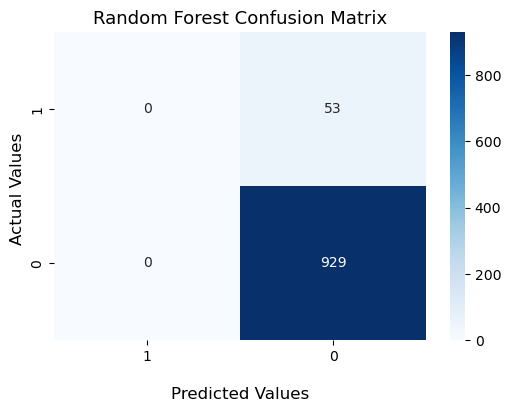

In [35]:
y_pred = forest_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Random Forest Confusion Matrix", fontsize = 13)
plt.show()

## Model 7: Voting

A voting classifier takes a set of estimators/models. Its effectiveness will depend on the diversity of the models (complexity and inherent stability properties) and performance of each model. The best combination/set can be determined with the help of cross-validation, but I will just try two combinations.

"A common strategy is to include 3 to 5 diverse and well-performing models in the VotingClassifier. This number is usually enough to capture the diversity of the models and improve the overall accuracy of the classifier without increasing the computational cost too much."

#### Voting Model 1: Reducing False Negatives Overall

In my first voting model setup, I want to address the amount of type II errors, or presence of false negatives. In this setting, this means that the prediction is no stroke when the reality is that it is a stroke. I want to lower the amount of false negatives because in the real world setting, this is arguably more dangerous than the alternative of saying someone has a stroke when they don't. 

Therefore, I take two models where the amount of false negatives is the least (Perceptron and Decision Tree), and a third that has better properties (Random Forest). All three of these models have high accuracy to start with, and hopefully we can get higher accuracy by lowering the count of false negatives overall. If we consider the misclassifications, they are also diverse in terms of their false positive/negative counts (see table in Conclusions section).

In [36]:
voting_model = VotingClassifier(estimators=[
    ('per', per_model), ('dt7', tree_model7), ('rf', forest_model)])
voting_model.fit(X_train, y_train)

print("Training accuracy:", voting_model.score(X_train, y_train))
print("Testing accuracy:", voting_model.score(X_test, y_test))

Training accuracy: 0.962821492233257
Testing accuracy: 0.945010183299389


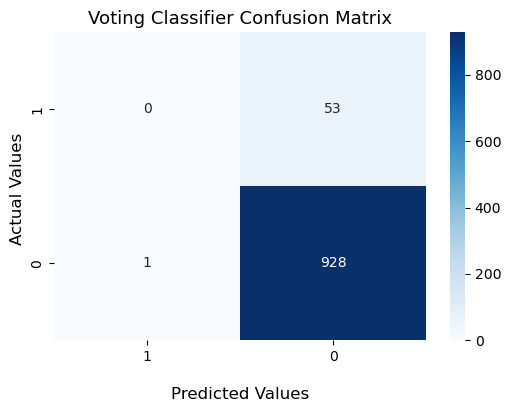

In [37]:
y_pred = voting_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Voting Classifier Confusion Matrix", fontsize = 13)
plt.show()

The false negative count has increased to 53, matching that of the random forest estimator fed into this voting model. Training and testing accuracy are comparable/similar to that of each of the individual estimator models fed into this voting model, so in practice I don't think it's worth using the voting model. In theory, however, this class of ensemble methods can combine these models and produce more accurate results, so it is still worth investigating.

#### Voting Model 2: Using High Testing Accuracy Models

Next, I take the 3 models with the highest testing accuracy (I won't use training accuracy in this case because of the imbalanced data, and high training accuracy may signify overfitting, but in practice involving the testing set like this isn't a great idea). I'll also throw in the Perceptron for fun for a total of 4 estimators because of its lower false negative count, and see how this voting model will perform.

In [38]:
voting_model2 = VotingClassifier(estimators=[
    ("per", per_model), ("log", log_model), ("mlp", mlp_model), ("rf", forest_model)])
voting_model2.fit(X_train, y_train)

print("Training accuracy:", voting_model2.score(X_train, y_train))
print("Testing accuracy:", voting_model2.score(X_test, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


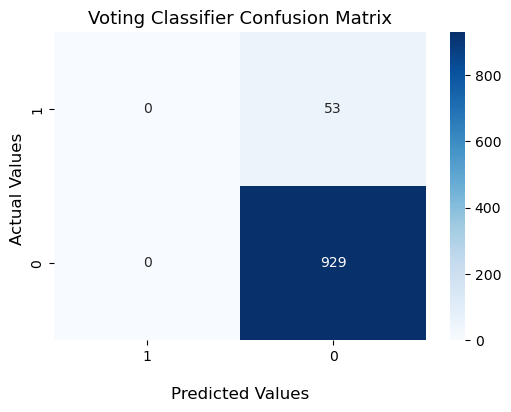

In [39]:
y_pred = voting_model2.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Voting Classifier Confusion Matrix", fontsize = 13)
plt.show()

The 2nd voting model I implemented only correctly identifies one additional case compared to the 1st voting model I implemented. This is very marginal compared to the greater increase in model complexity/computation, so I will say that my first voting model with 3 estimators is better.

## Model 8: Gradient Boosting

For my last model, I will implement boosting. Specifically, I will examine gradient boosting, which does better performance-wise and is much more flexible and robust to outliers than AdaBoost.

#### Finding the best model under different learning rates

In [40]:
boosting_rates = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
for rate in boosting_rates:
    boosting_model = GradientBoostingClassifier(learning_rate = rate, n_estimators = 200, max_depth = 1, random_state = 42)
    boosting_model.fit(X_train, y_train)
    print(f"rate = {rate}: {boosting_model.score(X_train, y_train)}")

rate = 0.001: 0.9602750190985485
rate = 0.01: 0.9602750190985485
rate = 0.1: 0.961038961038961
rate = 0.5: 0.9615482556659027
rate = 1: 0.9633307868601986
rate = 5: 0.9602750190985485
rate = 10: 0.15839062897886427
rate = 50: 0.03972498090145149
rate = 100: 0.03972498090145149
rate = 500: 0.03972498090145149
rate = 1000: 0.8416093710211358


When the learning rate is 1, the training accuracy is highest. However, high learning rates can lead to overfitting. To create a more generalized and robust model, I'll use 0.01 as the learning rate to proceed with.

#### Performance/Error Analysis

In [41]:
boosting_model = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 200, max_depth = 1, random_state = 42)
boosting_model.fit(X_train, y_train)

print("Training accuracy:", boosting_model.score(X_train, y_train))
print("Testing accuracy:", boosting_model.score(X_test, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


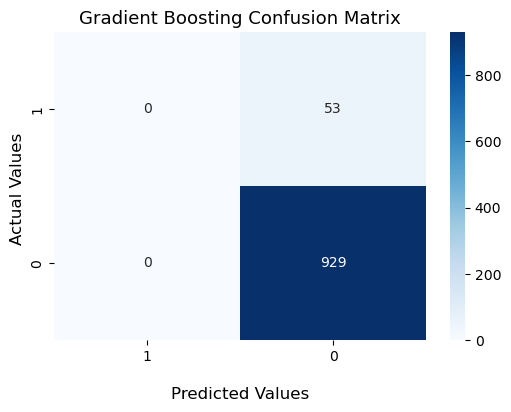

In [42]:
y_pred = boosting_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Gradient Boosting Confusion Matrix", fontsize = 13)
plt.show()

## Feature Selection

Up until now, all of the models involved the full feature set. This may lead to more complex/overfit models overall. Using random forests, the importance of each feature can be calculated. Now, I am going to perform feature selection, subset the dataset to these variables, and then rerun all the previous analysis to see if there will be an improvement in results. Specifically, noting that all of the models above had similar performance, I want to see if there will be more of a range in performances with fewer features involved in training.

In [43]:
# Output each feature's importance
for ft, imp in zip(X_train.columns, forest_model.feature_importances_):
    print(f"{abs(imp):.3f} - {ft}")

0.026 - gender
0.278 - age
0.037 - hypertension
0.037 - heart_disease
0.021 - ever_married
0.046 - work_type
0.025 - Residence_type
0.291 - avg_glucose_level
0.185 - bmi
0.055 - smoking_status


Only 3 variables have an importance greater than 0.1 - age, avg_glucose_level, and bmi. The `SelectFromModel` function selects only these three variables to be kept.

In [44]:
trimmed_model = SelectFromModel(forest_model, prefit=True)
cols_keep = list(X_train.columns[trimmed_model.get_support()])
cols_drop = list(X_train.columns[~trimmed_model.get_support()])
print("Keeping:", cols_keep)
print("Dropping:", cols_drop)

Keeping: ['age', 'avg_glucose_level', 'bmi']
Dropping: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


Now, I update the X matrices to rerun all the previous models using this lower dimensionality feature set.

In [45]:
#X_train2 = trimmed_model.transform(X_train)
#X_test2 = trimmed_model.transform
X_train2 = X_train.drop(cols_drop, axis = 1)
X_test2 = X_test.drop(cols_drop, axis = 1)

### a) Rerunning the Perceptron

In [46]:
learning_rates = [0.8, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for eta in learning_rates:
    per_model2 = Perceptron(eta0 = eta, max_iter = 5000, random_state = 42)
    per_model2.fit(X_train2, y_train)
    print(f"rate = {eta}: {per_model2.score(X_train2, y_train)}")

rate = 0.8: 0.9582378405907818
rate = 0.5: 0.9582378405907818
rate = 0.25: 0.9582378405907818
rate = 0.1: 0.9582378405907818
rate = 0.01: 0.9582378405907818
rate = 0.001: 0.9582378405907818
rate = 0.0001: 0.9582378405907818
rate = 1e-05: 0.9582378405907818


No learning rate leads to a better model over another, I'll just use 0.0001.

In [47]:
per_model2 = Perceptron(eta0 = 0.0001, max_iter = 5000, random_state = 42)
per_model2.fit(X_train2, y_train)

print("Training accuracy:", per_model2.score(X_train2, y_train))
print("Testing accuracy:", per_model2.score(X_test2, y_test))

Training accuracy: 0.9582378405907818
Testing accuracy: 0.9460285132382892


Comparing these accuracies to those from the Perceptron model for the full feature set (below), the model does better after performing feature selection!

In [48]:
print("Training accuracy:", per_model.score(X_train, y_train))
print("Testing accuracy:", per_model.score(X_test, y_test))

Training accuracy: 0.949834479246244
Testing accuracy: 0.9439918533604889


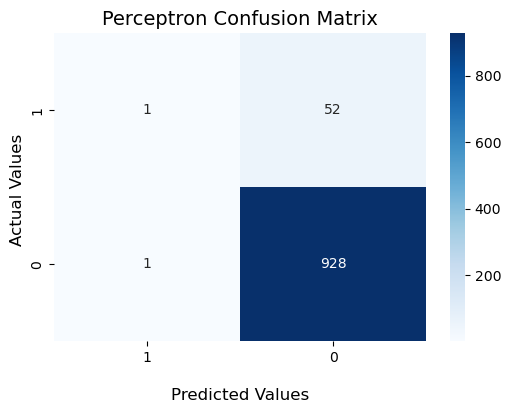

In [49]:
# Confusion matrix for model post feature selection
y_pred = per_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Perceptron Confusion Matrix", fontsize = 14)
plt.show()

### b) Rerunning Logistic Regression

In [50]:
log_model2 = LogisticRegression(random_state = 42)
log_model2.fit(X_train2, y_train)
print("Training accuracy:", log_model2.score(X_train2, y_train))
print("Testing accuracy:", log_model2.score(X_test2, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


Comparing these accuracies to those from the model for the full feature set (below), the model has essentially the same accuracy after performing feature selection.

In [51]:
print("Training accuracy:", log_model.score(X_train, y_train))
print("Testing accuracy:", log_model.score(X_test, y_test))

Training accuracy: 0.9605296664120193
Testing accuracy: 0.9460285132382892


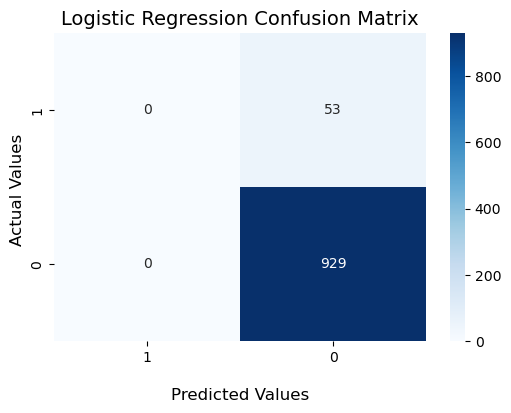

In [52]:
# Confusion matrix for model post feature selection
y_pred = log_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Logistic Regression Confusion Matrix", fontsize = 14)
plt.show()

### c) Rerunning Multilayer Perceptron

In [53]:
for lr in learning_rates:
    mlp_model2 = MLPClassifier(learning_rate_init = lr, max_iter = 500, random_state = 42)
    mlp_model2.fit(X_train2, y_train)
    print(f"rate = {lr}: {mlp_model2.score(X_train2, y_train)} with {mlp_model2.n_layers_} layers")

rate = 0.8: 0.9602750190985485 with 3 layers
rate = 0.5: 0.9602750190985485 with 3 layers
rate = 0.25: 0.9602750190985485 with 3 layers
rate = 0.1: 0.9602750190985485 with 3 layers
rate = 0.01: 0.9602750190985485 with 3 layers
rate = 0.001: 0.9602750190985485 with 3 layers
rate = 0.0001: 0.9600203717850777 with 3 layers
rate = 1e-05: 0.9590017825311943 with 3 layers


In [54]:
mlp_model2 = MLPClassifier(learning_rate_init = 0.01, max_iter = 500, random_state = 42)
mlp_model2.fit(X_train2, y_train)

print("Training accuracy:", mlp_model2.score(X_train2, y_train))
print("Testing accuracy:", mlp_model2.score(X_test2, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


Comparing these accuracies to those from the model for the full feature set (below), the model has the same accuracy after performing feature selection.

In [55]:
print("Training accuracy:", mlp_model.score(X_train, y_train))
print("Testing accuracy:", mlp_model.score(X_test, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


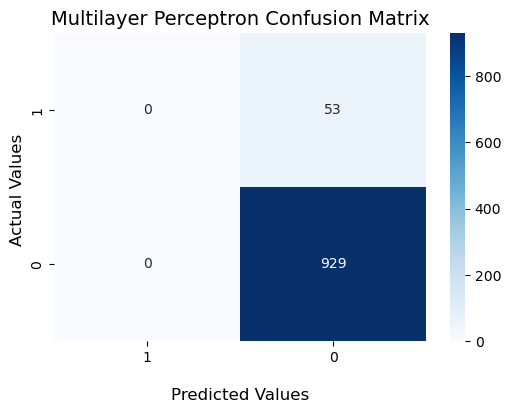

In [56]:
# Confusion matrix for model post feature selection
y_pred = mlp_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Multilayer Perceptron Confusion Matrix", fontsize = 14)
plt.show()

### d) Rerunning *k*-Nearest Neighbors

In [57]:
# Evaluate accuracy for a range of k to pick the optimal value
knn_accuracy = []
possible_k = range(3, 16)
for k in possible_k:
    knn2 = KNeighborsClassifier(n_neighbors = k)
    knn2.fit(X_train2, y_train)
    knn_accuracy.append(knn2.score(X_train2, y_train))

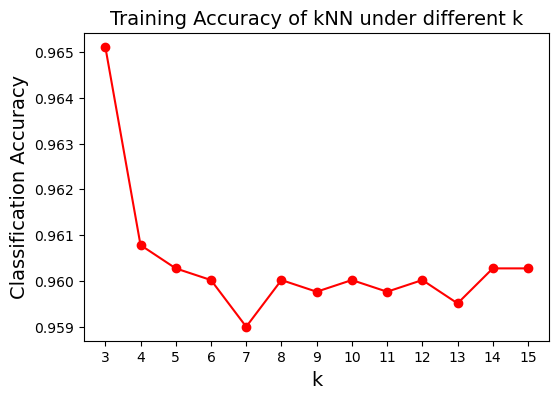

In [58]:
plt.figure(figsize = (6, 4))
plt.plot(possible_k, knn_accuracy, color = 'red', marker = "o")
plt.title("Training Accuracy of kNN under different k", fontsize = 14)
plt.xlabel('k', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)
plt.xticks(possible_k)
plt.show()

Interestingly, this plot looks exactly like the previous one with the full feature set.

In [59]:
knn2 = KNeighborsClassifier(n_neighbors = 3)
knn2.fit(X_train2, y_train)

print("Training accuracy:", knn2.score(X_train2, y_train))
print("Testing accuracy:", knn2.score(X_test2, y_test))

Training accuracy: 0.9651133180544945
Testing accuracy: 0.9338085539714868


Comparing these accuracies to those from the model for the full feature set (below), the model has slightly better training accuracy but slightly worse testing accuracy after performing feature selection. The difference is very marginal, however.

In [60]:
print("Training accuracy:", knn.score(X_train, y_train))
print("Testing accuracy:", knn.score(X_test, y_test))

Training accuracy: 0.964349376114082
Testing accuracy: 0.9348268839103869


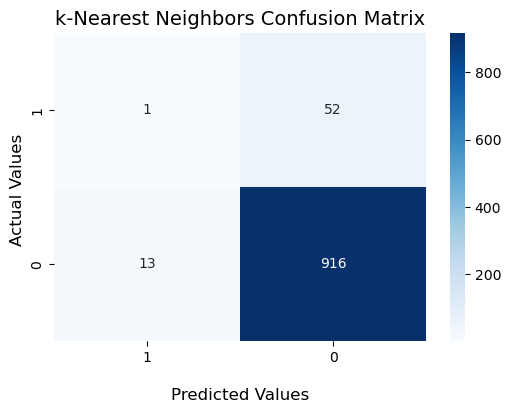

In [61]:
# Confusion matrix for model post feature selection
y_pred = knn2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("k-Nearest Neighbors Confusion Matrix", fontsize = 14)
plt.show()

### e) Rerunning Decision Trees

In [62]:
# Obtain the accuracy and bias/variance for each Decision Tree to select the best depth
tree_accuracy = []
biases = []
variances = []
possible_depth = range(2, 21)
for d in possible_depth:
    tree_model2 = DecisionTreeClassifier(max_depth = d, random_state = 42)
    tree_model2.fit(X_train2, y_train)
    tree_accuracy.append(tree_model2.score(X_train2, y_train))

    _, bias, var = bias_variance_decomp(tree_model2,
        X_train2.values, y_train.values, X_test2.values, y_test.values, loss = 'mse', random_seed = 123)
    biases.append(bias)
    variances.append(var)

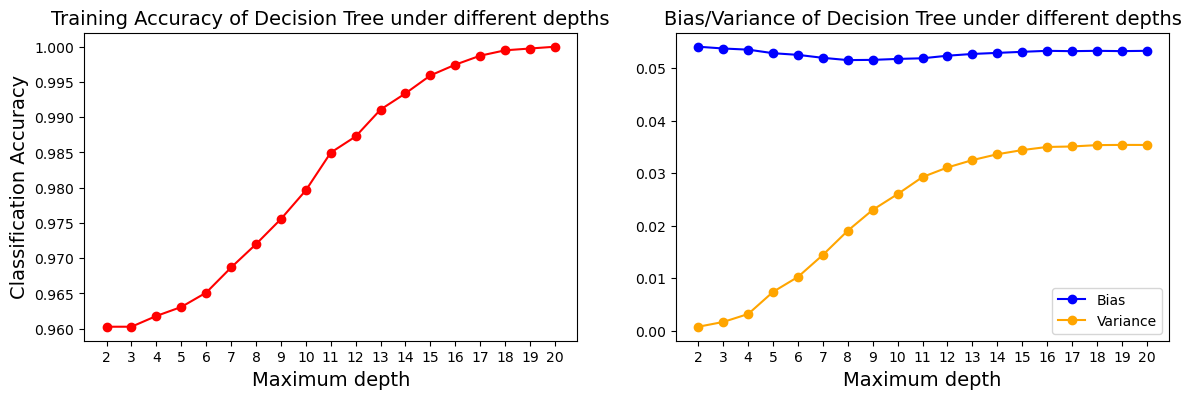

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
ax1.plot(possible_depth, tree_accuracy, color = 'red', marker = "o")
ax1.set_title("Training Accuracy of Decision Tree under different depths", fontsize = 14)
ax1.set_xlabel('Maximum depth', fontsize = 14)
ax1.set_ylabel('Classification Accuracy', fontsize = 14)
ax1.set_xticks(possible_depth)

ax2.plot(possible_depth, biases, color = 'blue', marker = "o", label = "Bias")
ax2.plot(possible_depth, variances, color = 'orange', marker = "o", label = "Variance")
ax2.set_title("Bias/Variance of Decision Tree under different depths", fontsize = 14)
ax2.set_xlabel('Maximum depth', fontsize = 14)
ax2.set_xticks(possible_depth)
ax2.legend(loc = "lower right")
plt.show()

Interestingly, these plots looks exactly like the previous ones with the full feature set. I will train the decision tree with `max_depth=7`.

In [64]:
tree_model2 = DecisionTreeClassifier(max_depth = 7, random_state = 42)
tree_model2.fit(X_train2, y_train)

# from sklearn.tree import plot_tree
# Would be good to display the actual tree but this one is too large

print("Training accuracy:", tree_model2.score(X_train2, y_train))
print("Testing accuracy:", tree_model2.score(X_test2, y_test))

Training accuracy: 0.9686783804430863
Testing accuracy: 0.9409368635437881


Comparing these accuracies to those from the model for the full feature set (below), the model has slightly worse training accuracy after performing feature selection, but there is an increase in testing accuracy by 4%! I'd say the Decision Tree with a maximum depth of 7 does better following feature selection.

In [65]:
print("Training accuracy:", tree_model.score(X_train, y_train))
print("Testing accuracy:", tree_model.score(X_test, y_test))

Training accuracy: 0.9730073847720907
Testing accuracy: 0.9022403258655805


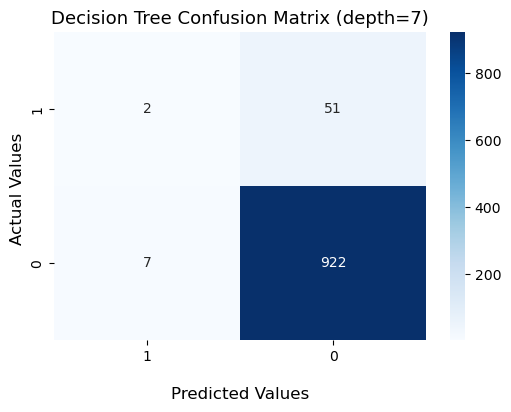

In [66]:
# Confusion matrix for model post feature selection
y_pred = tree_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Decision Tree Confusion Matrix (depth=7)", fontsize = 13)
plt.show()

### f) Rerunning Random Forest

In [67]:
forest_model2 = RandomForestClassifier(
    max_depth = 7, n_estimators = 500, bootstrap = True, n_jobs = -1, random_state = 42)
forest_model2.fit(X_train2, y_train)
#forest_y_pred = forest_clf.predict(X_test)
#print(f"Forest Classification Report")
#print(classification_report(y_test, forest_y_pred), "\n")

print("Training accuracy:", forest_model2.score(X_train2, y_train))
print("Testing accuracy:", forest_model2.score(X_test2, y_test))

Training accuracy: 0.9618029029793735
Testing accuracy: 0.9460285132382892


Comparing these accuracies to those from the model for the full feature set (below), the model has a slightly worse training accuracy following feature selecting, but the same testing accuracy.

In [68]:
print("Training accuracy:", forest_model.score(X_train, y_train))
print("Testing accuracy:", forest_model.score(X_test, y_test))

Training accuracy: 0.962821492233257
Testing accuracy: 0.9460285132382892


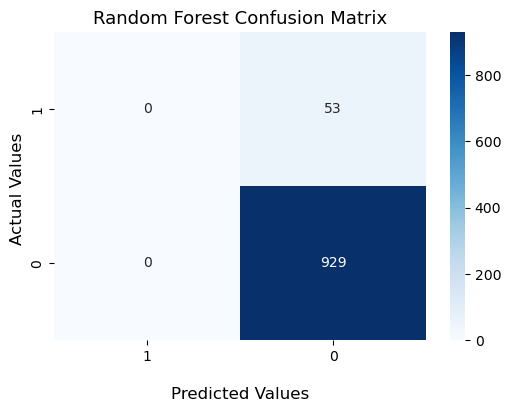

In [69]:
# Confusion matrix for model post feature selection
y_pred = forest_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Random Forest Confusion Matrix", fontsize = 13)
plt.show()

### g) Rerunning Voting

Rather than retrain a similar model as before using the full feature set, since the models used in my original voting model haven't changed in performance following feature selection, I'm going to try something different now that I realize Gradient Boosting gives different results in terms of classification. I will incorporate this model with different properties into the voting classifier and see what happens.

I will also involve the Perceptron and Random Forests as before, the first because of it's simplicity while also having slightly fewer false negative cases, and the latter because of its properties as an ensemble method. 

In [70]:
voting_model3 = VotingClassifier(estimators=[
    ("per", per_model2), ("knn", knn2), ("tree", tree_model2)])
voting_model3.fit(X_train2, y_train)

print("Training accuracy:", voting_model3.score(X_train2, y_train))
print("Testing accuracy:", voting_model3.score(X_test2, y_test))

Training accuracy: 0.962821492233257
Testing accuracy: 0.9460285132382892


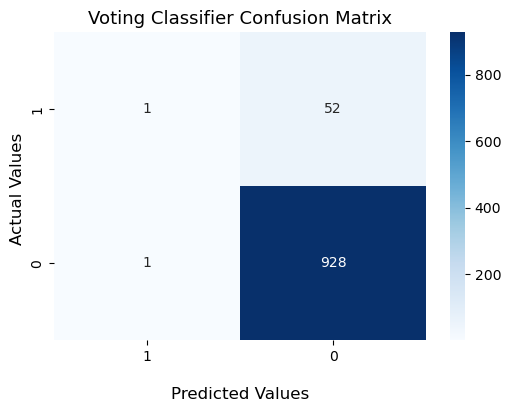

In [71]:
# Confusion matrix for model post feature selection
y_pred = voting_model3.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Voting Classifier Confusion Matrix", fontsize = 13)
plt.show()

While there is no improvement in the false negative rate, the model correctly predicts a true positive like the original models do. Most other models predict all zeroes, so this is a hopeful finding.

### h) Rerunning Gradient Boosting

In [72]:
for rate in boosting_rates:
    boosting_model2 = GradientBoostingClassifier(learning_rate = rate, n_estimators = 200, max_depth = 1, random_state = 42)
    boosting_model2.fit(X_train2, y_train)
    print(f"rate = {rate}: {boosting_model2.score(X_train2, y_train)}")

rate = 0.001: 0.9602750190985485
rate = 0.01: 0.9602750190985485
rate = 0.1: 0.9607843137254902
rate = 0.5: 0.9615482556659027
rate = 1: 0.9618029029793735
rate = 5: 0.9602750190985485
rate = 10: 0.15839062897886427
rate = 50: 0.03972498090145149
rate = 100: 0.03972498090145149
rate = 500: 0.03972498090145149
rate = 1000: 0.8416093710211358


Once again, I will use a learning rate of 0.01 because I want a more generalized and robust model. While a learning rate of 1 produces the model with the highest training accuracy, this higher learning rate can lead to overfitting.

In [73]:
boosting_model2 = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 200, max_depth = 1, random_state = 42)
boosting_model2.fit(X_train2, y_train)

print("Training accuracy:", boosting_model2.score(X_train2, y_train))
print("Testing accuracy:", boosting_model2.score(X_test2, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


Comparing these accuracies to those from the model for the full feature set (below), the model performs the exact same accuracy wise; there is no point in proceeding with the more complex model with more features under boosting.

In [74]:
print("Training accuracy:", boosting_model.score(X_train, y_train))
print("Testing accuracy:", boosting_model.score(X_test, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


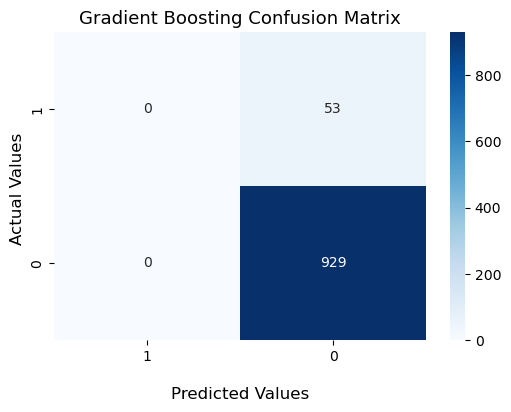

In [75]:
y_pred = boosting_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Gradient Boosting Confusion Matrix", fontsize = 13)
plt.show()

All of the models run up till now share the same problem of failing to classify positive cases...

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



By the interpretation of precision, out of all the people in the testing set that the model predicted has a stroke, 0% actually did.

By the interpretation of recall, out of all the people in the testing set that actually did have a stroke, the model predicted this outcome correctly for 0% of these people.

What can be done about this? An attempt is in the following section.

## Undersampling the Majority Class

Because the dataset is unbalanced, I'm going to try and fit models using a more balanced ratio to see if that changes anything. First, I am going undersampling the majority class, meaning reducing the amount of zeroes in the training set. I only undersample the training set instead of the full data as it is generally recommended to in order to avoid information leakage and prevent overfitting. I will also only use the 3 features from feature selection, since this will generate the simpler model without much change in performance as found previously.

Following the undersampling, I will fit a model for 2 ensemble methods: random forests and boosting. Ensemble methods have more robust properties for unbalanced data, so that is why I will focus on them. It would be worth examining more of the previous models too, however.

In [77]:
rus = RandomUnderSampler(random_state = 42)
X_rus, y_rus = rus.fit_resample(X_train2, y_train)

print("Original training observations count:", len(y_train))
print("Undersampling training observations count:", len(y_rus))

Original training observations count: 3927
Undersampling training observations count: 312


In [78]:
# Stroke values distribution after undersampling majority of 0s
y_rus.value_counts()

0    156
1    156
Name: stroke, dtype: int64

### a) Random Forests

I tried a different range of max_depth. At 6, the training/testing accuracies are 92.6% and 67.8% respectively. At 8, it is 96.4% and 68.43% respectively. Therefore, I'll just stay with 7 like I did in previous sections.

In [79]:
forest_model_rus = RandomForestClassifier(
    max_depth = 7, n_estimators = 500, bootstrap = True, n_jobs = -1, random_state = 42)
forest_model_rus.fit(X_rus, y_rus)

print("Training accuracy:", forest_model_rus.score(X_rus, y_rus))
print("Testing accuracy:", forest_model_rus.score(X_test2, y_test))

Training accuracy: 0.9423076923076923
Testing accuracy: 0.6843177189409368


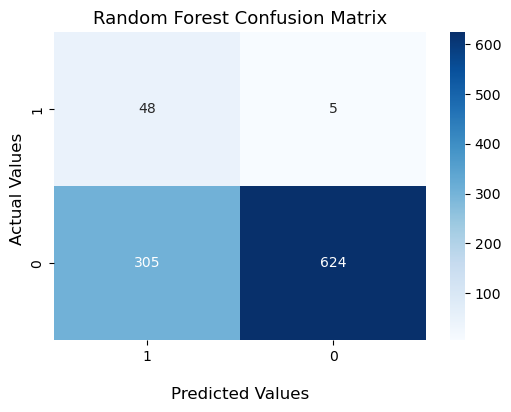

In [80]:
# Confusion matrix for model post undersampling
y_pred = forest_model_rus.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Random Forest Confusion Matrix", fontsize = 13)
plt.show()

Training accuracy decreased by 2% and testing accuracy is now 68% instead of the previous 94.6%. However, this model is actually able to capture the presence of 1's in the dataset, as indicated by the number of true positives exceeding 0 and decrease in false negatives to 5. With this also comes a large amount of false positives too.

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80       929
           1       0.14      0.91      0.24        53

    accuracy                           0.68       982
   macro avg       0.56      0.79      0.52       982
weighted avg       0.95      0.68      0.77       982



Out of all the people in the testing set that the model predicted has a stroke, only 14% actually did.

Out of all the people in the testing set that actually did have a stroke, the model predicted this outcome correctly for 91% of these people.

### b) Boosting

In [82]:
# Find an optimal learning rate
for rate in boosting_rates:
    boosting_model_rus = GradientBoostingClassifier(learning_rate = rate, n_estimators = 200, max_depth = 1, random_state = 42)
    boosting_model_rus.fit(X_rus, y_rus)
    print(f"rate = {rate}: {boosting_model_rus.score(X_rus, y_rus)}")

rate = 0.001: 0.7532051282051282
rate = 0.01: 0.7788461538461539
rate = 0.1: 0.8333333333333334
rate = 0.5: 0.8782051282051282
rate = 1: 0.9294871794871795
rate = 5: 0.5
rate = 10: 0.2467948717948718
rate = 50: 0.2467948717948718
rate = 100: 0.5
rate = 500: 0.7532051282051282
rate = 1000: 0.7532051282051282


In [83]:
boosting_model_rus = GradientBoostingClassifier(learning_rate = 1, n_estimators = 200, max_depth = 1, random_state = 42)
boosting_model_rus.fit(X_rus, y_rus)

print("Training accuracy:", boosting_model_rus.score(X_rus, y_rus))
print("Testing accuracy:", boosting_model_rus.score(X_test2, y_test))

Training accuracy: 0.9294871794871795
Testing accuracy: 0.675152749490835


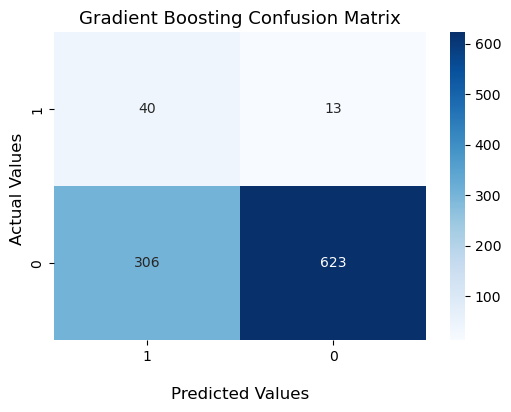

In [84]:
# Confusion matrix for model post undersampling
y_pred = boosting_model_rus.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Gradient Boosting Confusion Matrix", fontsize = 13)
plt.show()

Training accuracy decreased by about 4% and testing accuracy is now 68% instead of the previous 94.6%. However, this model is actually able to capture the presence of 1's in the dataset, as indicated by the number of true positives exceeding 0 and decrease in false negatives to 13. With this also comes a large amount of false positives too.

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.67      0.80       929
           1       0.12      0.75      0.20        53

    accuracy                           0.68       982
   macro avg       0.55      0.71      0.50       982
weighted avg       0.93      0.68      0.76       982



Out of all the people in the testing set that the model predicted has a stroke, only 12% actually did.

Out of all the people in the testing set that actually did have a stroke, the model predicted this outcome correctly for 75% of these people.

## Oversampling the Minority Class

Next, I will be oversampling the minority class and see how that changes anything. Again, I will only look at ensemble methods, but it would be worth examining more of the previous models.

In [86]:
ros = RandomOverSampler(random_state = 42)
X_ros, y_ros = ros.fit_resample(X_train2, y_train)

print("Original training observations count:", len(y_train))
print("Oversampling training observations count:", len(y_ros))

Original training observations count: 3927
Oversampling training observations count: 7542


In [87]:
# Stroke values distribution after oversampling minority of 1s
y_ros.value_counts()

0    3771
1    3771
Name: stroke, dtype: int64

### a) Random Forest

I tried a different range of max_depth and am going to settle on 9. Raising the max_depth to 10 would increase both training and testing accuracy by 1%, but I don't think it's worth it because the depth/complexity is already quite high. 93.7% training error is already pretty high considering how the training set is balanced now as well.

In [88]:
forest_model_ros = RandomForestClassifier(
    max_depth = 9, n_estimators = 500, bootstrap = True, n_jobs = -1, random_state = 42)
forest_model_ros.fit(X_ros, y_ros)

print("Training accuracy:", forest_model_ros.score(X_ros, y_ros))
print("Testing accuracy:", forest_model_ros.score(X_test2, y_test))

Training accuracy: 0.937682312383983
Testing accuracy: 0.8380855397148677


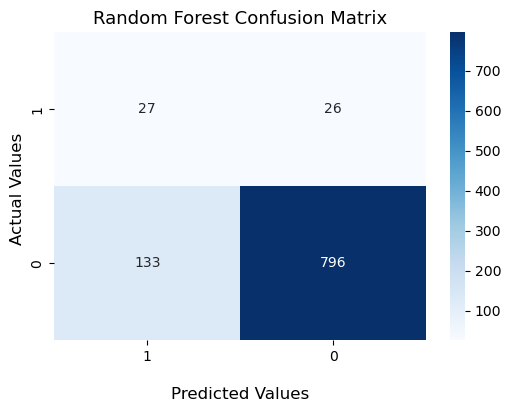

In [89]:
# Confusion matrix for model post oversampling
y_pred = forest_model_ros.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Random Forest Confusion Matrix", fontsize = 13)
plt.show()

Testing accuracy is now 83.8%. Compare this to the 94.6% of the original model and 68% from undersampling, while also accounting for the model's ability to capture the presence of 1's in the dataset, as indicated by the number of true positives exceeding 0 and decrease in false negatives to 26.

In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       929
           1       0.17      0.51      0.25        53

    accuracy                           0.84       982
   macro avg       0.57      0.68      0.58       982
weighted avg       0.93      0.84      0.87       982



Out of all the people in the testing set that the model predicted has a stroke, only 17% actually did.

Out of all the people in the testing set that actually did have a stroke, the model predicted this outcome correctly for 51% of these people.

### b) Boosting

In [91]:
# Confusion matrix for model post oversampling
for rate in boosting_rates:
    boosting_model_ros = GradientBoostingClassifier(learning_rate = rate, n_estimators = 200, max_depth = 1, random_state = 42)
    boosting_model_ros.fit(X_ros, y_ros)
    print(f"rate = {rate}: {boosting_model_ros.score(X_ros, y_ros)}")

rate = 0.001: 0.7619994696367012
rate = 0.01: 0.7619994696367012
rate = 0.1: 0.7821532749933705
rate = 0.5: 0.8310792893131795
rate = 1: 0.8516308671439936
rate = 5: 0.5
rate = 10: 0.2573587907716786
rate = 50: 0.2573587907716786
rate = 100: 0.5
rate = 500: 0.7426412092283214
rate = 1000: 0.7426412092283214


In [92]:
boosting_model_ros = GradientBoostingClassifier(learning_rate = 1, n_estimators = 200, max_depth = 1, random_state = 42)
boosting_model_ros.fit(X_ros, y_ros)

print("Training accuracy:", boosting_model_ros.score(X_ros, y_ros))
print("Testing accuracy:", boosting_model_ros.score(X_test2, y_test))

Training accuracy: 0.8516308671439936
Testing accuracy: 0.7535641547861507


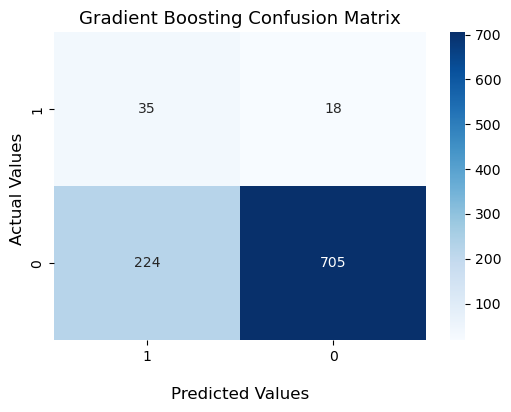

In [93]:
y_pred = boosting_model_ros.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Gradient Boosting Confusion Matrix", fontsize = 13)
plt.show()

Training accuracy is now 85% and testing accuracy is now 75%. Compare this to the 94.6% of the original model and 67.5% from undersampling, while also accounting for the model's ability to capture the presence of 1's in the dataset, as indicated by the number of true positives exceeding 0 and decrease in false negatives to 18. With this also comes a large amount of false positives too.

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85       929
           1       0.14      0.66      0.22        53

    accuracy                           0.75       982
   macro avg       0.56      0.71      0.54       982
weighted avg       0.93      0.75      0.82       982



Out of all the people in the testing set that the model predicted has a stroke, only 14% actually did.

Out of all the people in the testing set that actually did have a stroke, the model predicted this outcome correctly for 66% of these people.

## Conclusion

All of these models were run, and now the question arises - which is the best binary classifier for this data? Below, I will summarize the results and provide my final decision with reasoning.

### For all variables

Recall that blindly guessing 0 has a training accuracy of 96.03% and testing accuracy of 94.60%. Ideally the best model will have a high accuracy (mostly testing accuracy, since training accuracy is optimized to start with) and also hopefully surpass this metric.

| Model       | Training Accuracy | Testing Accuracy | True Positives | True Negatives | False Positives | False Negatives|
| ----------- | ----------------- | ---------------- | -------------- | -------------- | --------------- | -------------- |
| Blindly Guessing 0 | 96.03% | 94.60% | 0 | 929 | 0 | 53 |
| Perceptron | 94.98% | 94.40% | 5 | 922 | 7 | 48 |
| Logistic Regression | 96.05% | 94.60% | 0 | 929 | 0 | 53 |
| Multilayer Perceptron | 96.03% | 94.60% | 0 | 929 | 0 | 53 |
| kNN $(k=3)$ | 96.43% | 93.48% | 2 | 916 | 13 | 51 |
| Decision Tree (`max_depth=7`) | 97.07% | 93.67% | 2 | 918 | 11 | 51 |
| Random Forests | 96.28% | 94.60% | 0 | 929 | 0 | 53 |
| Voting (Perceptron, Tree, RF) | 96.28% | 94.50% | 1 | 928 | 1 | 53 |
| Gradient Boosting | 96.03% | 94.60% | 0 | 929 | 0 | 53 |


No models surpass the testing accuracy of 94.60% from just blindly guessing 0, but the logistic regression, multilayer perceptron, random forest, and gradient boosting all have the same testing accuracy of 94.60%. These three models have similar training accuracies too, within 0.3% of each other at the maximum.

One noteworthy mention is the Perceptron model. It a testing accuracy of 94.40%, but further more, it has 48 false negative cases, or type II errors. This is a lower than the false negative classifications in the other models. For this data, a false negative means that the model will predict that someone doesn't have a stroke when they do, which is dangerous. For this reason, I might recommend the kNN or Decision Tree too, although their improvement in false negative cases is lower and at a greater cost in terms of more false positive cases.

It's hard to make a clear argument which model is truly better. If the focus was minimizing false positive cases, the clear recommendation would be the **Perceptron**. If the focus was accuracy, I'd have to pick between **logistic regression, multilayer perceptron, and the 3 ensemble methods (random forests, voting, gradient boosting)**. Ensemble methods have the better properties. One issue with this dataset is that it is unbalanced; there are many more 0's than 1's for the `stroke` variable. Ensemble methods are able to address this issue better than a simpler model like logistic regression, for example.

### For age, avg_glucose_level, bmi only (feature selection)

Next, what is the best model when using the subsetted feature vector to train the model?

| Model       | Training Accuracy | Testing Accuracy |  True Positives | True Negatives | False Positives | False Negatives|
| ----------- | ----------------- | ---------------- | --------------- | -------------- | --------------- | -------------- |
| Blindly Guessing 0 | 96.03% | 94.60% | 0 | 929 | 0 | 53 |
| Perceptron | 95.82% | 94.60% | 1 | 928 |  1 | 52 |
| Logistic Regression | 96.03% | 94.60% | 0 | 929 | 0 | 53 |
| Multilayer Perceptron | 96.03% | 94.60% | 0 | 929 | 0 | 53 |
| kNN $(k=3)$ | 96.51% | 93.38% | 1 | 916 | 13 | 52 |
| Decision Tree (`max_depth=7`) | 96.87% | 94.09% | 2 | 922 | 7 | 51 |
| Random Forests | 96.28% | 94.60% | 0 | 929 | 0 | 53 |
| Voting (Perceptron, kNN, Tree) | 96.28% | 94.60% | 1 | 928 | 1 | 52 |
| Gradient Boosting | 96.03% | 94.60% | 0 | 929 | 0 | 53 |

The results are actually similar to the previous section. Nothing surpasses the accuracy of blindly guessing 0 still, but some models improve in performance compared to previously. For example, the decision tree improved in testing accuracy by 0.42% while also having 4 fewer false negative classifications.

In terms of false negative cases, no model has far fewer than the others. The Perceptron now has both fewer false positives and more false negatives when using only 3 features to predict.

In general, my overall recommendation would be the same as the previous section. **In conclusion**, the logistic regression, multilayer perceptron, random forest, voting, and gradient boosting models are all good binary classifiers for this dataset, given their performance for both feature sets. However, because of its properties for unbalanced data, I would suggest the ensemble methods such as **random forests/voting/gradient boosting** to lower the risk of dangerous misclassifications.

Perhaps the true solution to fitting the best model does not lie in which model works best for the data, but rather addressing the unbalanced nature of the data itself. With more `stroke=1` observations, it's likely that we would be able to train a model that can deal with these positive cases and perform better than a model that simply blindly guesses 0 all the time. **Having representative data is key to training a good model.** The next section talks about models that tried to address the imbalance in the data.

### Ensemble Methods Post Random Undersampling/Oversampling

| Model       | Training Accuracy | Testing Accuracy |  True Positives | True Negatives | False Positives | False Negatives| Precision | Recall |
| ----------- | ----------------- | ---------------- | --------------- | -------------- | --------------- | -------------- | --------- | ------ |
| Blindly Guessing 0 | -- | 94.60% | 0 | 929 | 0 | 53 | 0% | 0% | 
| Undersampling Random Forest | 94.23% | 68.43% | 48 | 624 | 305 |  5 | 14% | 91% |
| Undersampling Boosting      | 92.95% | 67.52% | 40 | 623 | 306 | 13 | 12% | 75% |
| Oversampling Random Forest  | 93.77% | 83.81% | 27 | 796 | 133 | 26 | 17% | 51% |
| Oversampling Boosting       | 85.16% | 75.36% | 35 | 705 | 224 | 18 | 14% | 66% |

These 4 models have lower accuracy than the ones summarized in the above sections, but addressing the imbalanced data allowed for a model that recognized the presence of positives. The best model once again depends on context; if we're going off of accuracy, random forest after performing random oversampling did the best of the 4, but none of these perform better than the previous models summarized above. However, given the imbalance in the data, using accuracy score as a metric for determining the best model can be misleading to start with.

Considering other metrics besides accuracy, if trying to increase the number of true positives, lower the number of false negatives (because of the dangers of not diagnosing), and ignoring the amount of false positives (assuming it's okay to misdiagnose), then **random forest** after performing **random undersampling** is worth mentioning. Based on the precision, out of all the people in the testing set that this model predicted has a stroke, only 14% actually did. In terms of recall, however, out of all the people in the testing set that actually did have a stroke, the model predicted this outcome correctly for 91% of these people!

Given the context of the data, I conclude that **random forest** after performing **random undersampling** is the **best classifier out of the ones I explored**.